<a href="https://www.kaggle.com/code/kermercan/audio-project?scriptVersionId=241429172" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import shutil
import os
import numpy as np
import seaborn as sns
!pip install resampy
!pip install librosa
import librosa
from librosa.effects import pitch_shift as librosa_pitch_shift
from librosa.effects import time_stretch as librosa_time_stretch

import resampy
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout, Input, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications import efficientnet_v2
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import gc
from PIL import Image
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 43.0 MB/s eta 0:00:00


In [2]:
def create_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
        BatchNormalization(), 
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(), 
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(), 
        MaxPooling2D((2, 2)),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(), 
        MaxPooling2D((2, 2)),
        Conv2D(512, (3, 3), activation='relu', padding='same'),
        BatchNormalization(), 
        MaxPooling2D((2, 2)),
        
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.25),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Parametreler
input_shape = [256, 256, 1]  # Giriş şekli (1 kanal - grayscale)
num_classes = 10
n_epochs = 100
batch_size = 64
learning_rate = 0.001
fixed_sample_rate = 44100
n_mels = 256
image_size = (256, 256)

# Verisetinin yolu
train_data_path = "/kaggle/input/yldz-teknik-proje-1-train-dataset/Train/"
train_label_path = "/kaggle/input/yldz-teknik-proje-1-train-dataset/Train.csv"

# CSV'yi oku
df_train = pd.read_csv(train_label_path)
df_train.head()

# Özellikler ve etiketler için boş listeler
feature = []
label = []

# Ses dosyalarını işleme
for i in tqdm(range(len(df_train))):
    file_name = train_data_path + df_train.iloc[i]["file_name"]
    y, sr = librosa.load(file_name, sr=fixed_sample_rate)
    
    # Mel-spektrogram oluştur
    mels = librosa.feature.melspectrogram(y=y, sr=fixed_sample_rate, n_mels=n_mels, fmax=fixed_sample_rate // 2)
    mels = librosa.amplitude_to_db(mels, ref=np.max)
    
    # Görselleştirme ve yeniden boyutlandırma
    im = Image.fromarray(np.uint8(mels / np.max(np.abs(mels)) * 255))
    im = im.resize(image_size, resample=Image.Resampling.LANCZOS)
    mels_resized = np.array(im) / 255.0  # Normalize (0-1)
    
    # Özellik ve etiket ekleme
    feature.append(mels_resized)
    label.append(df_train.iloc[i]["classID"])

# Özellikler ve etiketlerin numpy dizisine dönüştürülmesi
X = np.expand_dims(np.stack(feature, axis=0), axis=3)  # Kanal boyutu ekleme
Y = np.array(label)
Y = to_categorical(Y)

# Veri setini bölme
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.2, random_state=1)

# DÜZELTME 1: ImageDataGenerator konfigürasyonu
# Eğer önceden işlenmiş numpy array'leri kullanıyorsanız, rescale=1./255 kullanmayın
# Çünkü veriler zaten 0-1 arasında normalize edilmiş
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest'
    # rescale=1./255 KALDIRILDI - veriler zaten normalize
)

# DÜZELTME 2: Eğer numpy array'leri kullanıyorsanız, flow_from_directory yerine flow kullanın
# Veya directory yapısı kullanıyorsanız, o zaman ImageDataGenerator'ı farklı şekilde yapılandırın

# SEÇENEK A: Numpy array'leri kullanmak (mevcut yaklaşımınız)
train_gen = train_datagen.flow(
    X_train, 
    Y_train,
    batch_size=batch_size,
    shuffle=True,
    seed=42
)

# Validation için augmentation yapmayın
val_datagen = ImageDataGenerator()  # rescale kaldırıldı
val_gen = val_datagen.flow(
    X_valid,
    Y_valid,
    batch_size=batch_size,
    shuffle=False
)

# Model parametreleri
model_name = "kerim"

# Sınıf ağırlıklarını hesapla
classes = np.unique(Y_train.argmax(axis=1))
class_weights = compute_class_weight('balanced', classes=classes, y=Y_train.argmax(axis=1))
class_weight_dict = {i: class_weights[i] for i in range(len(classes))}

# Model oluştur ve derle
model = create_model(input_shape, num_classes)
optim = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbackler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, min_lr=1e-6, verbose=1)
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
model_checkpoint_cb = ModelCheckpoint(filepath=model_name + '_best.keras', monitor='val_loss', save_best_only=True, verbose=1)
tensorboard_cb = TensorBoard(log_dir=os.path.join("logs", model_name), histogram_freq=1)

callbacks = [lr_scheduler, early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

# DÜZELTME 3: Model eğitimi - çakışan validation_data parametreleri düzeltildi
history = model.fit(
    train_gen,  # generator kullanın
    epochs=n_epochs,
    validation_data=val_gen,  # sadece bir validation_data
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)
# Modeli kaydet
model.save(model_name + '.keras')
print(f"Model {model_name}.keras olarak kaydedildi.")

100%|██████████| 7057/7057 [06:03<00:00, 19.39it/s]
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.1475 - loss: 4.0072

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 2.30138, saving model to kerim_best.keras
89/89 ━━━━━━━━━━━━━━━━━━━━ 48s 356ms/step - accuracy: 0.1476 - loss: 3.9966 - val_accuracy: 0.1126 - val_loss: 2.3014 - learning_rate: 0.0010
Epoch 2/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.1670 - loss: 2.3260
Epoch 2: val_loss improved from 2.30138 to 2.29979, saving model to kerim_best.keras
89/89 ━━━━━━━━━━━━━━━━━━━━ 24s 254ms/step - accuracy: 0.1671 - loss: 2.3258 - val_accuracy: 0.1126 - val_loss: 2.2998 - learning_rate: 0.0010
Epoch 3/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.1873 - loss: 2.1715
Epoch 3: val_loss did not improve from 2.29979
89/89 ━━━━━━━━━━━━━━━━━━━━ 24s 250ms/step - accuracy: 0.1873 - loss: 2.1717 - val_accuracy: 0.0460 - val_loss: 4.5616 - learning_rate: 0.0010
Epoch 4/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.1917 - loss: 2.1706
Epoch 4: val_loss improved from 2.29979 to 2.18280, saving model to kerim_best.keras
89/89 ━━━━━━━━

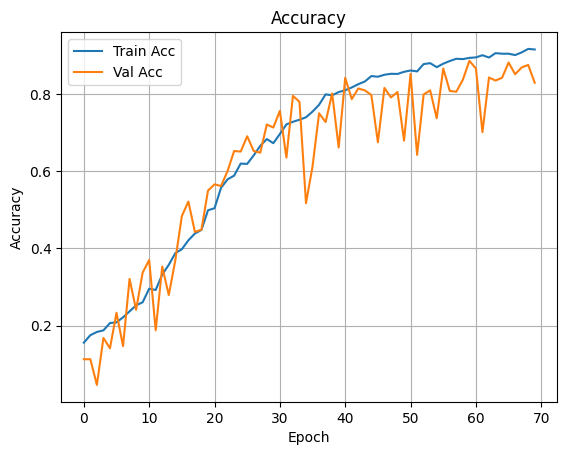

In [3]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.title('Accuracy')
plt.show()


In [4]:
!pip install gdown
import gdown

# Test veri yolu ve etiketleri
test_data_path = "/kaggle/input/yldz-teknik-proje-1-train-dataset/Test_Public/"
test_label_path = "/kaggle/input/yldz-teknik-proje-1-train-dataset/Test_Public.csv"
df_test = pd.read_csv(test_label_path)

feature_test = []
label_test = []

for i in tqdm(range(len(df_test))):
    file_name = test_data_path + df_test.iloc[i]["file_name"]
    
    # Ses dosyasını yükle ve yeniden örnekle
    X, sr = librosa.load(file_name, sr=fixed_sample_rate)
    
    # Mel-spektrogram oluştur
    mels = librosa.feature.melspectrogram(y=X, sr=fixed_sample_rate, n_mels=n_mels, fmax=fixed_sample_rate // 2)
    mels = librosa.amplitude_to_db(mels, ref=np.max)  # Logaritmik skala
    
    # Görselleştirme ve yeniden boyutlandırma
    im = Image.fromarray(np.uint8(mels / np.max(np.abs(mels)) * 255))  # 0-255 ölçekleme
    im = im.resize(image_size, resample=Image.Resampling.LANCZOS)  # Daha iyi interpolasyon
    mels_resized = np.array(im) / 255.0  # Normalize (0-1)

    feature_test.append(mels_resized)
    label_test.append(df_test.iloc[i]["classID"])

# Özellikler ve etiketlerin numpy dizisine dönüştürülmesi
X_test = np.expand_dims(np.stack(feature_test, axis=0), axis=3)
Y_test = np.array(label_test)
Y_test = to_categorical(Y_test)

# Modeli yükleme
url = "https://drive.google.com/uc?export=download&id=18R4e01IEjA89ImCqQB-HifBgBU4CZs5z"
output = 'kerim.keras'
gdown.download(url, output, quiet=False)

model = tf.keras.models.load_model(output)

# Test verisi ile tahmin yapma
predictions = model.predict(X_test)

# Test seti değerlendirme
score_test = model.evaluate(X_test, Y_test)

print(f"Test Loss: {score_test[0]}")
print(f"Test Accuracy: {score_test[1]}")

100%|██████████| 82/82 [00:04<00:00, 20.43it/s]
Downloading...
From (original): https://drive.google.com/uc?export=download&id=18R4e01IEjA89ImCqQB-HifBgBU4CZs5z
From (redirected): https://drive.google.com/uc?export=download&id=18R4e01IEjA89ImCqQB-HifBgBU4CZs5z&confirm=t&uuid=8fd07462-5fe2-4300-8a9b-8545d4f9103b
To: /kaggle/working/kerim.keras
100%|██████████| 69.3M/69.3M [00:01<00:00, 64.1MB/s]


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 677ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step - accuracy: 0.3584 - loss: 3.0272
Test Loss: 2.772810459136963
Test Accuracy: 0.45121949911117554


In [5]:
import tensorflow as tf
import gc
import os
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import numpy as np
import pandas as pd
import librosa
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical

# GPU Memory Management
print("Configuring GPU memory...")
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled")
    except RuntimeError as e:
        print(f"GPU configuration error: {e}")

# Clear any existing models/variables
tf.keras.backend.clear_session()
gc.collect()

def create_lightweight_model(input_shape, num_classes):
    """Lightweight model to reduce memory usage"""
    base = EfficientNetB0(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape
    )
    base.trainable = False
    
    # Simpler head to reduce parameters
    x = base.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x)
    outputs = Dense(num_classes, activation="softmax")(x)
    
    return Model(inputs=base.input, outputs=outputs)

def process_audio_batch(file_paths, sr=22050, n_mels=128, image_size=(224, 224)):
    """Process audio files in smaller batches to manage memory"""
    batch_features = []
    
    for file_path in file_paths:
        try:
            # Use smaller parameters to reduce memory
            y, _ = librosa.load(file_path, sr=sr, duration=2.0)  # 2 seconds
            
            # Ensure consistent length
            target_length = sr * 2
            if len(y) < target_length:
                y = np.pad(y, (0, target_length - len(y)), mode='constant')
            else:
                y = y[:target_length]
            
            # Smaller mel-spectrogram
            mels = librosa.feature.melspectrogram(
                y=y, sr=sr, n_mels=n_mels, hop_length=512
            )
            mels_db = librosa.amplitude_to_db(mels, ref=np.max)
            
            # Normalize
            mels_normalized = (mels_db - mels_db.min()) / (mels_db.max() - mels_db.min())
            mels_uint8 = (mels_normalized * 255).astype(np.uint8)
            
            # Convert to RGB
            im = Image.fromarray(mels_uint8)
            im_resized = im.resize(image_size, resample=Image.Resampling.LANCZOS)
            mel_array = np.array(im_resized) / 255.0
            
            if len(mel_array.shape) == 2:
                mel_rgb = np.stack([mel_array, mel_array, mel_array], axis=-1)
            else:
                mel_rgb = mel_array
                
            batch_features.append(mel_rgb)
            
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            continue
    
    return batch_features

def train_memory_efficient():
    """Memory efficient training approach"""
    
    # Reduced parameters for memory efficiency
    input_shape = (224, 224, 3)  # Smaller input size
    num_classes = 10
    n_epochs = 25
    batch_size = 16  # Much smaller batch size
    learning_rate = 0.0001
    
    # Data paths
    train_data_path = "/kaggle/input/yldz-teknik-proje-1-train-dataset/Train/"
    train_label_path = "/kaggle/input/yldz-teknik-proje-1-train-dataset/Train.csv"
    
    # Load data
    df_train = pd.read_csv(train_label_path)
    print(f"Total data: {len(df_train)}")
    
    # Use even smaller sample to avoid memory issues
    n_files = min(1000, len(df_train))  # Reduced sample size
    df_sample = df_train.sample(n=n_files, random_state=42).reset_index(drop=True)
    print(f"Using {len(df_sample)} samples")
    
    # Process in small batches
    features = []
    labels = []
    batch_size_processing = 50  # Process 50 files at a time
    
    print("Processing audio files in batches...")
    for i in tqdm(range(0, len(df_sample), batch_size_processing)):
        batch_end = min(i + batch_size_processing, len(df_sample))
        batch_df = df_sample.iloc[i:batch_end]
        
        file_paths = [train_data_path + fname for fname in batch_df["file_name"]]
        batch_features = process_audio_batch(file_paths)
        
        # Add successful features and labels
        for j, feature in enumerate(batch_features):
            if feature is not None:
                features.append(feature)
                labels.append(batch_df.iloc[j]["classID"])
        
        # Force garbage collection
        gc.collect()
    
    if len(features) == 0:
        print("ERROR: No data processed!")
        return
    
    print(f"Successfully processed {len(features)} files")
    
    # Convert to arrays in smaller chunks to avoid memory spike
    print("Converting to arrays...")
    X = np.array(features, dtype=np.float32)  # Use float32 instead of float64
    Y = to_categorical(np.array(labels), num_classes=num_classes)
    
    # Clear features list to free memory
    del features
    gc.collect()
    
    print(f"X shape: {X.shape}")
    print(f"Y shape: {Y.shape}")
    
    # Split data
    X_train, X_val, Y_train, Y_val = train_test_split(
        X, Y, test_size=0.2, random_state=42, stratify=Y
    )
    
    # Clear original arrays
    del X, Y
    gc.collect()
    
    # Calculate class weights
    class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(Y_train.argmax(axis=1)),
        y=Y_train.argmax(axis=1)
    )
    class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
    print(f"Class weights: {class_weight_dict}")
    
    # Create model
    print("Creating model...")
    model = create_lightweight_model(input_shape, num_classes)
    
    # Compile with mixed precision for memory efficiency
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    
    # Callbacks
    callbacks = [
        ReduceLROnPlateau(
            monitor='val_loss', 
            factor=0.5, 
            patience=5,
            min_lr=1e-7, 
            verbose=1
        ),
        EarlyStopping(
            monitor='val_loss', 
            patience=10,
            restore_best_weights=True, 
            verbose=1
        )
    ]
    
    # Train model
    print("Starting training...")
    history = model.fit(
        X_train, Y_train,
        validation_data=(X_val, Y_val),
        epochs=n_epochs,
        batch_size=batch_size,
        class_weight=class_weight_dict,
        callbacks=callbacks,
        verbose=1
    )
    
    return model, history

# Memory monitoring function
def print_memory_usage():
    """Print current memory usage"""
    import psutil
    process = psutil.Process(os.getpid())
    memory_mb = process.memory_info().rss / 1024 / 1024
    print(f"Memory usage: {memory_mb:.1f} MB")

# Run training with memory monitoring
if __name__ == "__main__":
    print_memory_usage()
    
    # Enable mixed precision for better memory efficiency
    tf.keras.mixed_precision.set_global_policy('mixed_float16')
    
    try:
        model, history = train_memory_efficient()
        print("Training completed successfully!")
        print_memory_usage()
        
        # Save model
        model.save('audio_classifier.keras')
        print("Model saved!")
        
    except Exception as e:
        print(f"Training failed: {e}")
        # Clear memory and try again with even smaller parameters
        tf.keras.backend.clear_session()
        gc.collect()
        
# Alternative: Even more aggressive memory saving
def ultra_low_memory_training():
    """Ultra low memory training for very limited resources"""
    
    # Minimal parameters
    input_shape = (128, 128, 3)  # Very small input
    num_classes = 10
    n_epochs = 15
    batch_size = 8  # Very small batch
    n_files = 500  # Very small dataset
    
    print("Ultra low memory mode activated")
    # ... implement with even smaller parameters

Configuring GPU memory...
GPU configuration error: Physical devices cannot be modified after being initialized
Memory usage: 15189.0 MB
Total data: 7057
Using 1000 samples
Processing audio files in batches...


100%|██████████| 20/20 [00:21<00:00,  1.06s/it]


Successfully processed 1000 files
Converting to arrays...
X shape: (1000, 224, 224, 3)
Y shape: (1000, 10)
Class weights: {0: 0.7766990291262136, 1: 1.5384615384615385, 2: 0.8888888888888888, 3: 0.9302325581395349, 4: 0.9090909090909091, 5: 0.851063829787234, 6: 2.962962962962963, 7: 0.8695652173913043, 8: 1.0526315789473684, 9: 0.8695652173913043}
Creating model...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Starting training...
Epoch 1/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 31s 251ms/step - accuracy: 0.0950 - loss: 2.3725 - val_accuracy: 0.1150 - val_loss: 2.3037 - learning_rate: 1.0000e-04
Epoch 2/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.0893 - loss: 2.2712 - val_accuracy: 0.1150 - val_loss: 2.3031 - learning_rate: 1.0000e-04
Epoch 3/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.1067 - loss: 2.3165 - val_accuracy: 0.1100 - val_loss: 2.3026 - learning_rate: 1.0000e-04
Epoch 4/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.0959 - loss: 2.3284 - val_a

In [6]:
print(X_train.shape, Y_train.shape)

(5645, 256, 256, 1) (5645, 10)
